In [1]:
# %matplotlib notebook

import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def getCupLocation2D(fname):
    low_H = 0.621 * 180
    low_S = 0.409 * 255
    low_V = 0.235 * 255
    high_H = 0.694 * 180
    high_S = 0.947 * 255
    high_V = 0.871 * 255
    
    img = cv2.imread(fname)

    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_threshold = cv2.inRange(img_HSV, (low_H, low_S, low_V), (high_H, high_S, high_V))
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_threshold, 4, cv2.CV_32S)

    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    # find component with largest area (excluding first component)
    cup_label = np.argmax(stats[1:,4]) + 1 

    return labeled_img, centroids[cup_label]

In [3]:
# ZED Instrinsic parameters
# based on SN26462030.conf
# Options: 2K, FHD, HD, VGA

RT1 = np.concatenate((np.eye(3), np.zeros((3,1))), axis=1)

R, jacob = cv2.Rodrigues(np.array([0.0027161, 0, 0.000430528]))
T = np.array([[119.837, 0.0441432, -0.0386536]]).T

RT2 = np.concatenate((R, T), axis=1)

M1_2K = np.array([[1059.75, 0, 1118.19], 
                  [0, 1058.99, 615.079], 
                  [0, 0, 1]])

M2_2K = np.array([[1059.55, 0, 1147.19], 
                  [0, 1058.64, 634.958], 
                  [0, 0, 1]])

# k1, k2, p1, p2, k3
dist1_2K = np.array([[-0.0435878, 0.0129137, -0.000229128, 0.000790854, -0.00592556]])
dist2_2K = np.array([[-0.0398599, 0.00700217, -0.000241005, 0.000243961, -0.00359243]])

M1 = M1_2K
M2 = M2_2K
dist1 = dist1_2K
dist2 = dist2_2K

P1 = np.matmul(M1, RT1)
P2 = np.matmul(M2, RT2)

In [5]:
# triangulation of points
labeled_img1, x1 = getCupLocation2D('calibration/calibration_picture/up1.jpg')
labeled_img2, x2 = getCupLocation2D('calibration/calibration_picture/down1.jpg')

image_size = (1920, 1080)

R1, R2, P1, P2, Q, ROI1, ROI2 = cv2.stereoRectify(M1, dist1, M2, dist2, image_size, R, T)

x1 = cv2.undistortPoints(x1, M1, dist1, R=R1, P=P1)
x2 = cv2.undistortPoints(x2, M2, dist2, R=R2, P=P2)

X = cv2.triangulatePoints(P1, P2, x1, x2)
X = X/X[3]
X = X[0:3]

print(X)

[[  15.52007591]
 [ -18.41277812]
 [-337.08984593]]


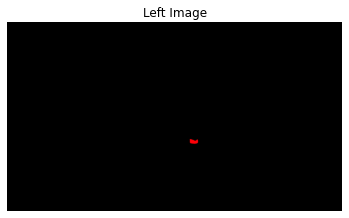

In [6]:
# show image for left camera
plt.imshow(cv2.cvtColor(labeled_img1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Left Image")
plt.show()

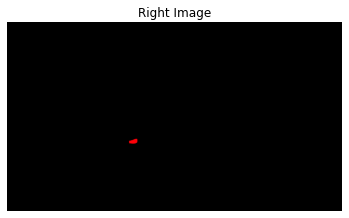

In [7]:
# show image for right camera
plt.imshow(cv2.cvtColor(labeled_img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Right Image")
plt.show()